# Dimensionality Reduction

Dimensionality reduction is a technique used in machine learning and statistics to reduce the number of input variables in a dataset. More input features often make a model more complex, increasing the risk of overfitting and making the model harder to interpret. Dimensionality reduction techniques aim to simplify models without losing much information.

---

### Why is Dimensionality Reduction Important?

1. **Simplification**: Makes the dataset easier to explore and visualize.
2. **Speed**: Reduces the computational complexity, making algorithms run faster.
3. **Data Compression**: Allows for more efficient storage of data.
4. **Noise Reduction**: Helps to eliminate irrelevant features or reduce noise.
5. **Improved Performance**: Can lead to better model performance when irrelevant features are removed.

---

### Example: Customer Segmentation in Retail

Imagine you're a data scientist at a retail company. The company collects data on customer transactions, online activity, customer service interactions, and more. In total, you have hundreds of features for each customer.

**The Problem**: You want to segment your customer base to target marketing more effectively, but the high dimensionality of your data makes it difficult to gain any meaningful insights.

**The Solution**: By applying dimensionality reduction techniques like PCA, you can reduce your hundreds of features to just a few principal components. These components can effectively summarize the essential information in the dataset, making it easier to perform customer segmentation.

**Outcome**: The marketing team can now more effectively tailor strategies for different segments, thereby increasing customer engagement and revenue.

## Overview

1. The curse of dimensionality
2. PCA
3. Factor Analysis
4. Adaptive Methods: t-SNE and UMAP

---

# The Curse of Dimensionality

 In high dimensions, the behavior of data can be counterintuitive, and algorithms that work well in low dimensions can become ineffective or computationally expensive.  This is because the available "space" that training samples are embedded grows exponentially with respect to the data.  This has several ramifications:

 - Distances between items become larger
 - Difference between distances become smaller
 - The amount of data required to cover the space grows exponentially

 See [this explanation](https://www.visiondummy.com/2014/04/curse-dimensionality-affect-classification/) to help guide your intuitions.

### The Hughes Phenomenon ###

In the late 70’s, G. Hughes observed a strange phonomenon while observing large datasets. It is best summarized by the picture below. 

![The Hughes Phenomenon](./assets/hughes_phenomenon.png)

Intuitively, it would be easy to understand that the more inputs (features) you provide the model, the more the predictive power of the model. However, after a certain point the accuracy of the prediction drops off. This is the essence of Hughes Phenomonon. It is based on the fact that measuring data (features or variables) typically has some level of error to it. When you compound this error over a large number of variables, the error explodes so much that the accuracy is affected.

### It Depends!

The curse of dimensionality depends heavily on the distribution of data in a space, the measurements used to calculate distance, and the algorithm applied.  For instance, KNN is highly susceptible to the curse of dimensionality, and Euclidean distances tend to perform worse than either Manhattan or cosine.  So, it's always worth exploring your data a little before you decide whether or not to worry about it!

---

### Experiments with dimensionality

The following code illustrates how increasing dimensionality increases distance.

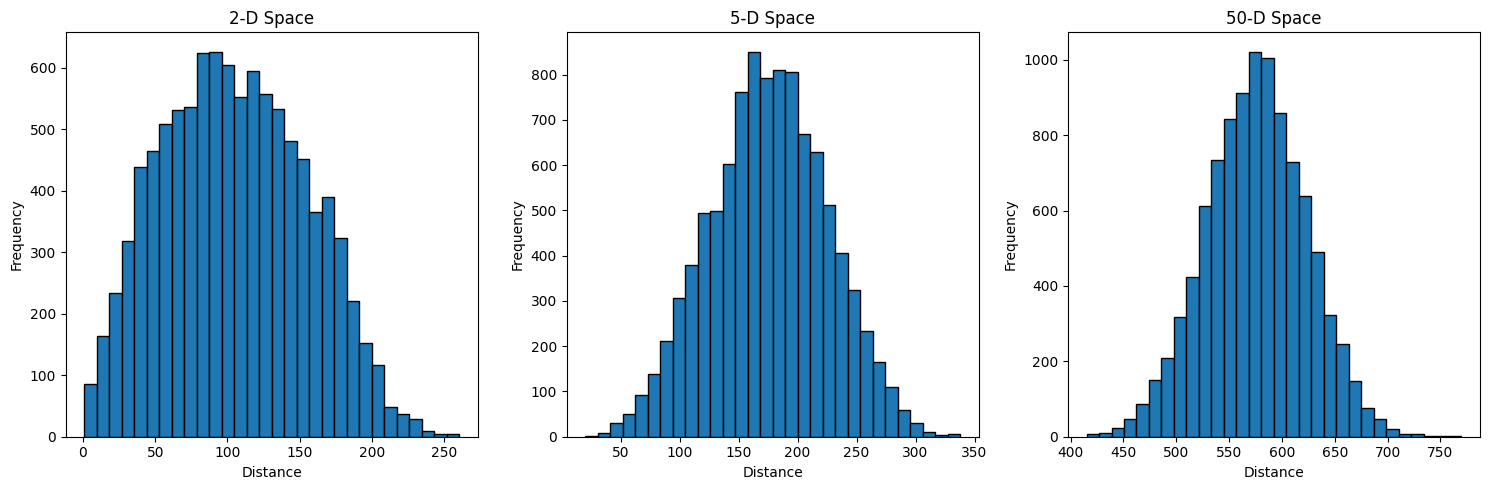

In [54]:
import numpy as np
import matplotlib.pyplot as plt

def generate_points(num_points, num_dimensions):
    return[np.random.randint(-100, 100, num_dimensions) for _ in range(num_points)]

def euclidean_distance(point1, point2):
    return np.sqrt(np.sum((point1 - point2) ** 2))

def compute_pairwise_distances(points_x,points_y):
    distances = []
    for i,j in zip(points_x,points_y):
        distances.append(euclidean_distance(i,j))
    return np.array(distances)

# Set the number of points and dimensions
num_points = 10000

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Loop through a few different dimensions
for ax, num_dimensions in zip(axes, [2, 5, 50]):
    # Generate points in unit hypercube
    points_x = generate_points(num_points, num_dimensions)
    points_y = generate_points(num_points, num_dimensions)

    # Compute pairwise distances
    distances = compute_pairwise_distances(points_x,points_y)
    
    # Plot histogram of distances
    ax.hist(distances, bins=30, edgecolor='black')
    ax.set_title(f"{num_dimensions}-D Space")
    ax.set_xlabel("Distance")
    ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

### Exercise

1. Can you create a loop and evaluate the mean distance for dimensions from 0 - 500? 

---

###

However, observe that the relative differences between max an min in fact approach zero!

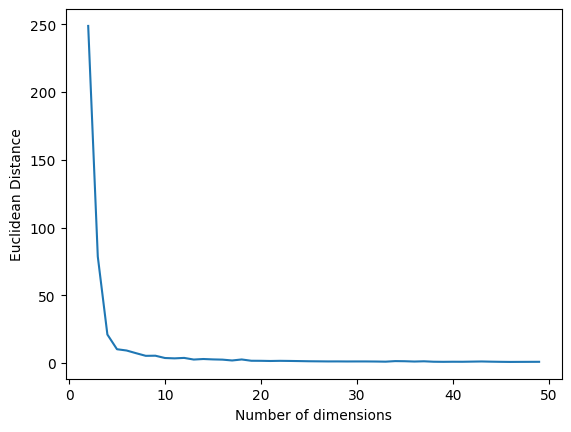

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math

deltas = []
for N in range(2,50):
    # Generate 1000 random points in N dimensions.
    P = [np.random.randint(-100, 100, N) for _ in range(10000)]
    Q = np.random.randint(-100,100,N)
    diffs = [np.linalg.norm(p-Q) for p in P]
    mxd = max(diffs)
    mnd = min(diffs)
    delta = (mxd-mnd)/mnd
    deltas.append( delta )

plt.plot(range(2,50),deltas)
plt.xlabel('Number of dimensions')
plt.ylabel('Euclidean Distance')
plt.show()

---
# Principle Components Analysis (PCA)

One way to reduce dimensionality is a principle components analysis (PCA).  PCA works by performing an eigenvector/eigenvalue decomposition of the data's covariance matrix. The goal is to transform the original features into a new set of uncorrelated features, known as principal components, which capture as much of the data's variance as possible. The first few principal components typically capture the majority of the variance, allowing for a lower-dimensional representation of the data.

### How does it work?

1. Center the data around the origin by subtracting the mean of each feature from the data points.

2. Calculate the covariance matrix, which captures how each feature varies with every other feature.

3. Compute the eigenvalues and eigenvectors of this covariance matrix. An eigenvector of a square matrix $A$ is a non-zero vector $\mathbf{v}$ that, when the matrix multiplies it, only scales the vector and does not change its direction. Mathematically, this can be written as $A\mathbf{v} = \lambda \mathbf{v}$

   Here, $A$ is the square matrix, $\mathbf{v}$ is the eigenvector, and $\lambda$ is the eigenvalue corresponding to this eigenvector. The eigenvalue controls how much the eigenvector is scaled. 
   
   **Intuition**: Imagine you have a rubber sheet that you can stretch, compress, or rotate. If you put an arrow (vector) on this sheet and then transform the sheet, most arrows would change both direction and length. However, some special arrows (eigenvectors) would only get "stretched" or "compressed" — they wouldn't change direction. The amount by which they get stretched or compressed is the eigenvalue. 

4. Eigenvalues are sorted in descending order, and the eigenvectors are rearranged correspondingly. The first eigenvalue will be the largest and indicates the maximum variance in the data that the first principal component (the corresponding eigenvector) captures.

5. To reduce dimensions, you can now select the first $k$ eigenvectors, where $k$ is the number of dimensions you want in your reduced dataset. You then project your original, centered data into this new \(k\)-dimensional subspace.

6. You can approximate the original data from the reduced data by projecting it back onto the original high-dimensional space by multiplying (dot-product) the transformed data with the transpose of the reduced eigenvector matrix.

### A Simple Example

First, we'll set up some sample data

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Step 1: Create synthetic 2D data
np.random.seed(0)
X = np.dot(np.random.rand(2, 2), np.random.randn(2, 200)).T

Now, the PCA, and the reconstruction:

In [57]:

# Step 2: Apply PCA and plot the rotated data
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Step 3: Apply PCA and plot the rotated data
X_reduced = PCA(n_components=1).fit_transform(X)
X_reconstructed = PCA(n_components=1).fit(X).inverse_transform(X_reduced)


Finally, plotting:

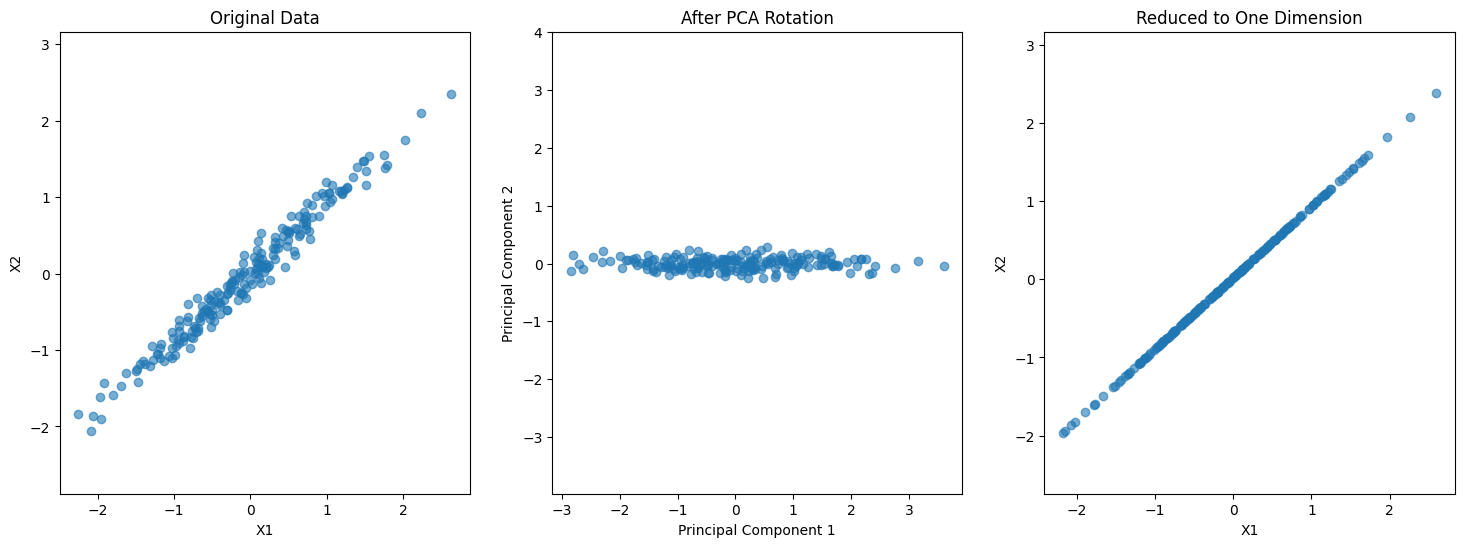

In [58]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.scatter(X[:, 0], X[:, 1], alpha=0.6)
plt.title("Original Data")
plt.xlabel("X1")
plt.ylabel("X2")
plt.axis('equal')



plt.subplot(1, 3, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.6)
plt.title("After PCA Rotation")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.axis('equal')

plt.subplot(1, 3, 3)
plt.scatter(X_reconstructed[:, 0], X_reconstructed[:, 1], alpha=0.6)
plt.title("Reduced to One Dimension")
plt.xlabel("X1")
plt.ylabel("X2")
plt.axis('equal')

plt.show()

### Selecting the right number of components

To select the right number of components, we can use the eigenvalues to calculate the amount of variance explained.  The variance explained by each principal component is directly related to the eigenvalues of the covariance matrix of the original dataset. Specifically, the proportion of variance explained by the $i^{th}$ principal component is given by:

$$
\text{Variance Explained}_i = \frac{\lambda_i}{\sum_{j=1}^{n} \lambda_j}
$$

where $\lambda_i$ is the eigenvalue corresponding to the $i^{th}$ principal component and $n$ is the number of components.

The eigenvalues are stored in decreasing order, and they measure the amount of variance along each principal component. A larger eigenvalue indicates that more variance is explained by that principal component.  We can visualize variance explained using a scree plot, and use the "elbow" method to select the number of components.

Variance Explained per Principal Component: [7.92556233e-01 7.41478585e-02 5.24005453e-02 3.51199136e-02
 2.11433667e-02 1.56168523e-02 4.84778213e-03 2.69208636e-03
 1.29776686e-03 1.77595141e-04]


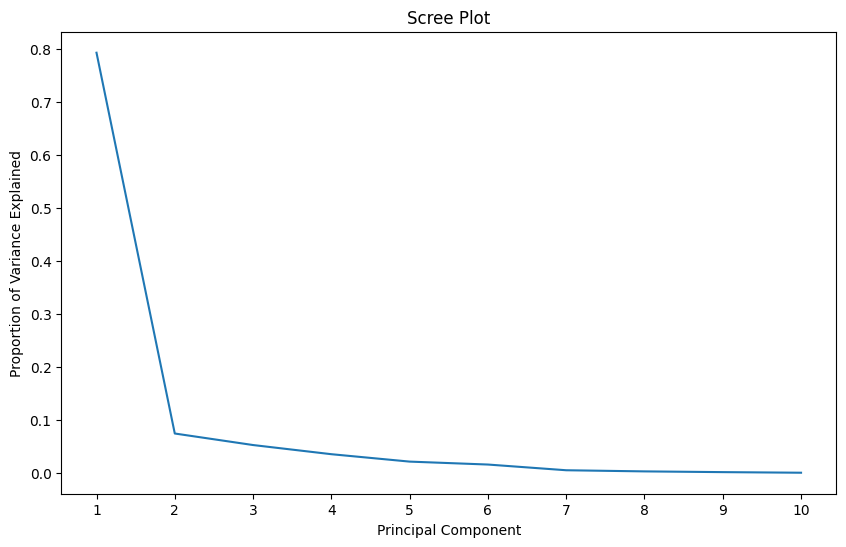

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Step 1: Create synthetic 10D data
np.random.seed(0)
X_high_dim = np.dot(np.random.rand(10, 10), np.random.randn(10, 200)).T

# Step 2: Apply PCA
pca_high_dim = PCA()  # although you can specify n_components, leaving out this parameter returns all
X_pca_high_dim = pca_high_dim.fit_transform(X_high_dim)

# Step 3: Calculate Variance Explained
variance_explained = pca_high_dim.explained_variance_ratio_
print("Variance Explained per Principal Component:", variance_explained)

# Step 4: Scree Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(variance_explained) + 1), variance_explained)
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.title('Scree Plot')
plt.xticks(range(1, len(variance_explained) + 1))
plt.show()

Alternatively, if you know how much variance you want to explain, you can easily calculate it like this:

In [60]:
# Calculate cumulative variance explained
cumulative_variance_explained = np.cumsum(pca_high_dim.explained_variance_ratio_)

# Find the number of components for desired explained variance
threshold = 0.95  # 95% variance
n_components = np.argmax(cumulative_variance_explained >= threshold) + 1
print(f"Number of components needed for {threshold*100}% variance: {n_components}")

Number of components needed for 95.0% variance: 4


Scikit learn also let's you specify the variance you want in advance and will automatically lift out the number of components you need, as long as your svd_solver is "full".

In [61]:
pca_high_dim = PCA(threshold)  # although you can specify n_components, leaving out this parameter returns all
X_pca_high_dim_auto = pca_high_dim.fit_transform(X_high_dim)

print(f"Number of components retrieved for {threshold*100}% = {X_pca_high_dim_auto.shape[1]}")

Number of components retrieved for 95.0% = 4


## Exercise 2

The MNIST data contains a large sample of handwritten letters.  Each letter is a 28x28 (768) grid of pixels, so the data is quite high dimensional.  Try using PCA to visualize the data.  I'll get you started with a little code below/

In [62]:
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Load MNIST data
mnist = fetch_openml("mnist_784", version=1)
X, y = mnist["data"].values, mnist["target"].astype(int).values

# Sample the dataset to speed up computation (Optional)
X, y = X[:7000], y[:7000]

# Split the dataset
X_mnist_train, X_mnist_test, y_mnist_train, y_mnist_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Visualize using PCA (2 components)
# Reduce the data with PCA

# You need to populate the following variable
X__mnist_reduced = None




/Users/jeintron/Dropbox/@TEACHING/2023/FALL23/DEV/ist407-707.venv/lib/python3.10/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


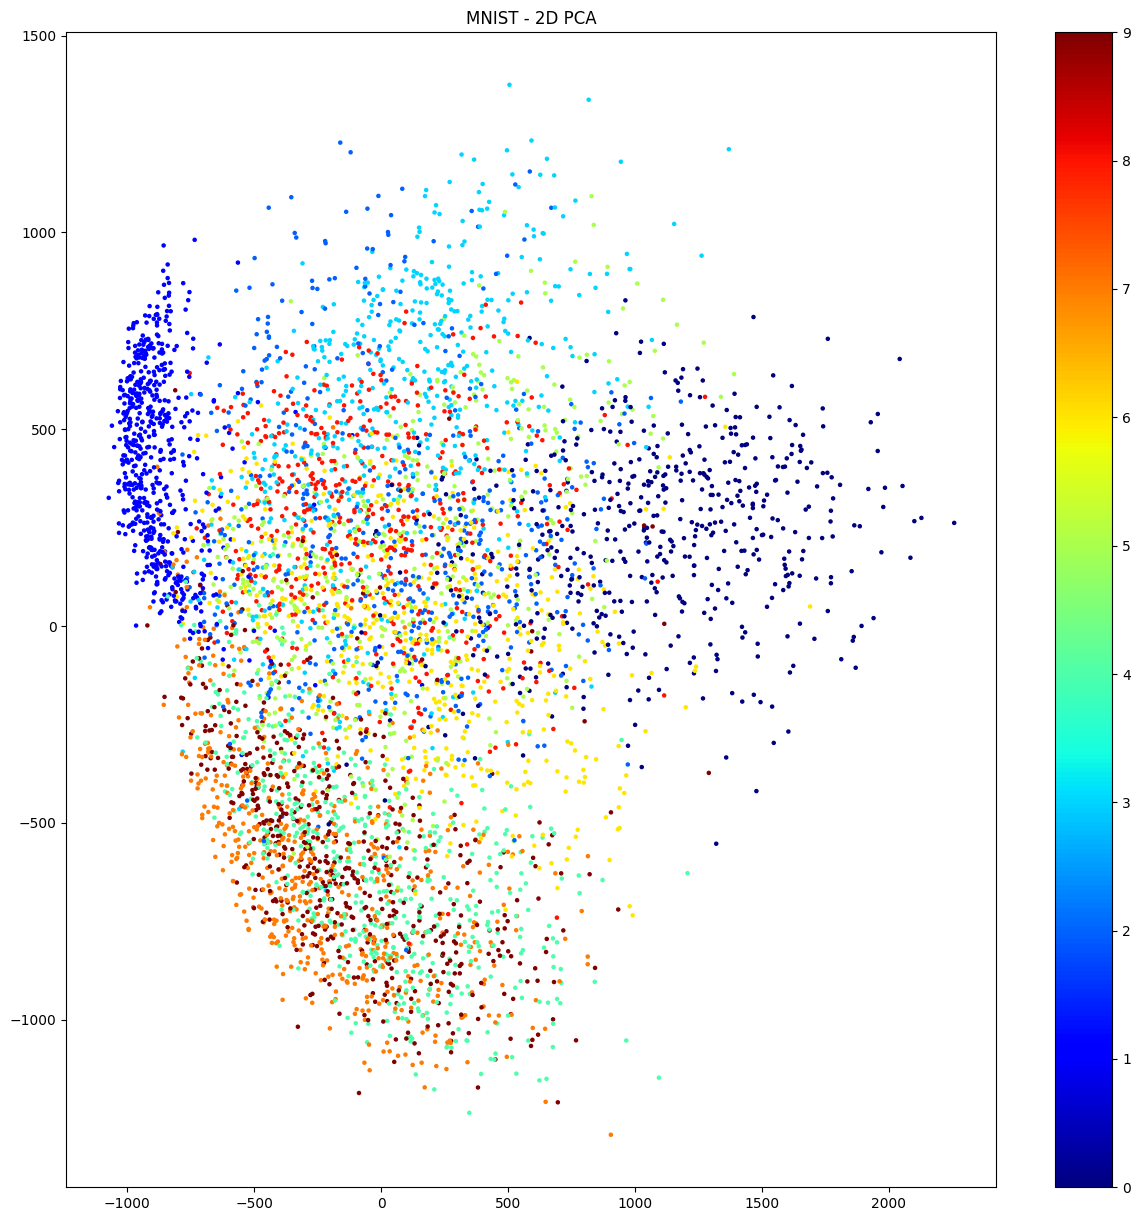

In [63]:
# Now plotting
plt.figure(figsize=(15,15))
plt.scatter(X_mnist_reduced[:, 0], X_mnist_reduced[:, 1], c=y_mnist_train, cmap="jet",s=5)
plt.colorbar()
plt.title("MNIST - 2D PCA")
plt.show()

Now the scree plot...

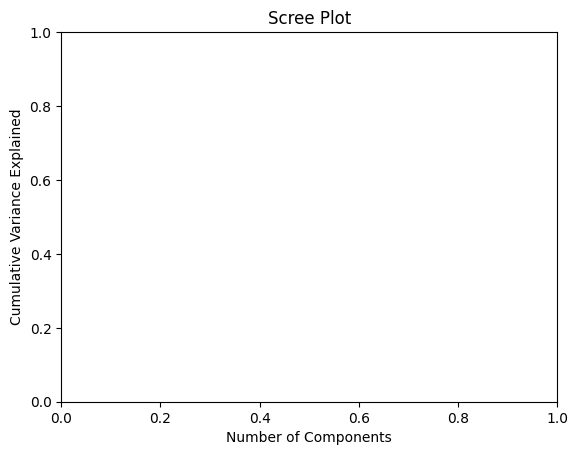

In [64]:

# Step 3: Scree Plot
pca_scree = None # What goes here???
# How do you get variance explained?
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Variance Explained")
plt.title("Scree Plot")
plt.show()


Choose the number of components to achieve 95% variance:

In [ ]:

# Step 4: Number of components for 95% variance
threshold = 0.95
n_components = None # What goes here???
print(f"Number of components for {threshold*100}% variance: {n_components}")

It's interesting to look at how a transform and reconstruction affects a single MNIST digit.  I've written a function to display a single digit.  Use PCA and the reconstruction method to have a look at this.  

In [ ]:
def plot_mnist_digit(digit):
    """Plot a single MNIST digit.

    Parameters:
    digit (numpy array): A flattened 1D numpy array of length 784.

    """
    # Reshape the flattened digit to 28x28 image
    digit_image = digit.reshape(28, 28)
    
    plt.imshow(digit_image, cmap='binary')
    plt.axis("off")
    plt.show()

plot_mnist_digit(X_mnist_train[0])

In [ ]:
# Use PCA with n_components to transform the above digit.  How does it look?

Use `n_components` to train a KNNClassifier, and compare accuracy to the non-reduced data.

In [ ]:
# Step 5: k-NN Classification
# Without PCA
knn = KNeighborsClassifier()
knn.fit(X_mnist_train, y_mnist_train)
y_pred = knn.predict(X_mnist_test)
print(f"Original Data Accuracy: {accuracy_score(y_mnist_test, y_pred)}")

# With PCA
# You have some work to do right here


y_pred_pca = None # How do you do this?
print(f"PCA-transformed Data Accuracy: {accuracy_score(y_mnist_test, y_pred_pca)}")


---

## Limitations of PCA

One of the key limitations of PCA is that it is a linear technique. This means that it works by finding new axes, called principal components, that are linear combinations of the original features. These principal components aim to capture as much variance in the data as possible. However, the linear nature of PCA imposes a limitation: it struggles to capture patterns in data that are fundamentally non-linear.

Imagine a dataset where points are distributed in a non-linear fashion, like a spiral or concentric circles. A linear method like PCA would not be able to capture the essence of such patterns. This is because the concept of "distance" or "variance" that PCA relies on does not adequately describe the intrinsic geometry of the data.

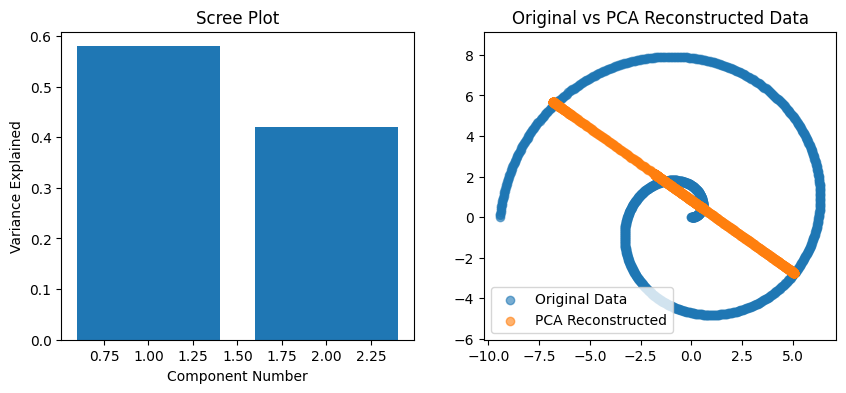

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Generate synthetic spiral data
n_points = 1000
n_turns = 3
t = np.linspace(0, n_turns * np.pi, n_points)
x = t * np.cos(t)
y = t * np.sin(t)

X_spiral = np.column_stack([x, y])

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_spiral)

# Scree Plot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.bar(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_)
plt.title("Scree Plot")
plt.xlabel("Component Number")
plt.ylabel("Variance Explained")

# Original Data vs PCA reconstruction
X_reduced = PCA(n_components=1).fit_transform(X_spiral)
X_reconstructed = PCA(n_components=1).fit(X_spiral).inverse_transform(X_reduced)

plt.subplot(1, 2, 2)
plt.scatter(X_spiral[:, 0], X_spiral[:, 1], alpha=0.6, label='Original Data')
plt.scatter(X_reconstructed[:, 0], X_reconstructed[:, 1], alpha=0.6, label='PCA Reconstructed')
plt.legend()
plt.axis('equal')
plt.title("Original vs PCA Reconstructed Data")

plt.show()


---

# Other Approaches

There are many many approach to dimesionality reduction.  Several extensions to PCA address it's limitations and extend it's capabilities.  One of these is **Kernel PCA**.

### Kernel PCA

Kernel Principal Component Analysis (Kernel PCA) is an extension of the standard Principal Component Analysis (PCA), designed to handle non-linear data effectively. While standard PCA works by finding linear principal components to project data onto, Kernel PCA works in an implicitly defined higher-dimensional feature space where these projections can be non-linear.

### How Kernel PCA Works

1. **Feature Space Mapping**: First, each data point in the original space is mapped into a higher-dimensional feature space using a kernel function $K(x_i, x_j)$. These are the same as with **Support Vector Machines**.

2. **Principal Component Analysis in Feature Space**: In this new feature space, the regular PCA algorithm is applied. Since working in a higher-dimensional space can be computationally intensive, Kernel PCA cleverly utilizes the "kernel trick" to compute principal components in the feature space without explicitly working in it.

3. **Projecting Data**: Finally, the original data is projected onto these new principal components in the feature space. The resulting data can be linearly separable even if the original data was not.

### Kernel Functions

Kernel PCA relies on the use of a kernel function to compute the similarity between pairs of data points in the feature space. Popular choices for kernel functions include:

- **Polynomial Kernel**: $K(x_i, x_j) = (x_i \cdot x_j + c)^d$
- **RBF (Radial Basis Function) or Gaussian Kernel**: $K(x_i, x_j) = \exp(-\gamma ||x_i - x_j||^2)$
- **Sigmoid Kernel**: $K(x_i, x_j) = \tanh(\alpha x_i \cdot x_j + c)$

### Advantages and Limitations

#### Advantages
- Can capture complex, non-linear relationships in data.
- Suitable for clustering, classification, and other tasks where linear methods fail.

#### Limitations
- Computationally more expensive compared to standard PCA.
- Requires choosing an appropriate kernel function and tuning its parameters, which may not be straightforward.

#### Example

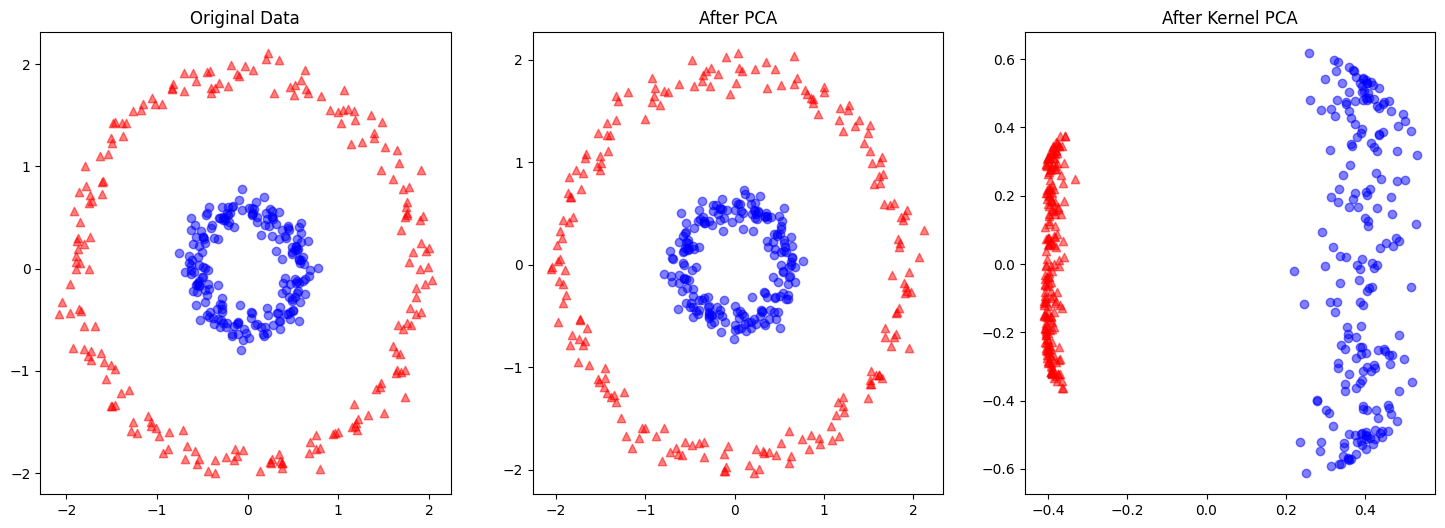

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.decomposition import KernelPCA, PCA
from sklearn.preprocessing import StandardScaler

# Generate synthetic data for concentric circles
np.random.seed(0)
X, y = make_circles(n_samples=400, factor=.3, noise=.05)

# Standardize the data
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Apply regular PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

# Apply Kernel PCA with Radial Basis Function (RBF) kernel
kpca = KernelPCA(kernel="rbf", gamma=1, n_components=2)
X_kpca = kpca.fit_transform(X_std)

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot original data
axes[0].scatter(X_std[y == 0, 0], X_std[y == 0, 1], color='red', marker='^', alpha=0.5)
axes[0].scatter(X_std[y == 1, 0], X_std[y == 1, 1], color='blue', marker='o', alpha=0.5)
axes[0].set_title("Original Data")

# Plot data transformed by PCA
axes[1].scatter(X_pca[y == 0, 0], X_pca[y == 0, 1], color='red', marker='^', alpha=0.5)
axes[1].scatter(X_pca[y == 1, 0], X_pca[y == 1, 1], color='blue', marker='o', alpha=0.5)
axes[1].set_title("After PCA")

# Plot data transformed by Kernel PCA
axes[2].scatter(X_kpca[y == 0, 0], X_kpca[y == 0, 1], color='red', marker='^', alpha=0.5)
axes[2].scatter(X_kpca[y == 1, 0], X_kpca[y == 1, 1], color='blue', marker='o', alpha=0.5)
axes[2].set_title("After Kernel PCA")

plt.show()

# Factor analysis

Factor Analysis as a statistical method used to describe variability among observed, correlated variables in terms of a potentially lower number of unobserved variables called factors. With PCA, we generally start with no knowledge of the underlying "meaning" of the data - we might engage in some kind of post-hoc construction, but typically PCA is a knowledge-lean method that involves no knowledge of the domain.  Factor analysis, on the other hand, assumes that the there are underlying "forces" that shape the data. The goal of factor analysis is to find evidence for these forces.

For example, in psychology, we might have a set of questionnaire responses that we believe reflect broader latent traits like extraversion or conscientiousness. Each question doesn't measure these traits directly, but together, they give us clues about their presence, much like how several landmarks might hint at the treasure's location. Factor analysis helps us quantify these traits and understand how each question relates to them.

It may be useful to contrast Factor Analysis with regression analysis as it used in the social sciences:

**Regression Analysis**:
- **Purpose**: It's primarily used for prediction and for testing hypotheses about relationships between dependent (outcome) and independent (predictor) variables.
- **Variables**: In regression, you have clearly defined dependent and independent variables. The independent variables are thought to influence the dependent variable directly, and they are measured without error.
- **Assumptions**: It assumes that there is a direct causal relationship between the variables.
- **Orientation**: It is typically predictive in nature, aiming to quantify the impact of one or more independent variables on a dependent variable.

**Factor Analysis**:
- **Purpose**: It's used for identifying latent constructs that aren't directly observed but are inferred from the relationships among observed variables.
- **Variables**: There are no explicitly defined independent or dependent variables at the outset. Instead, you have a set of observed variables that are believed to be influenced by a smaller number of unobserved factors.
- **Assumptions**: It assumes that the observed variables are manifestations of underlying factors. The factors themselves are what the analysis seeks to understand and quantify.
- **Orientation**: It is exploratory (or confirmatory, in the case of CFA) rather than predictive. The goal is to understand the structure of the data and the dimensions that underlie patterns of covariation.

So, in essence, while regression is about establishing a directional relationship from cause (independent variables) to effect (dependent variable), factor analysis is about uncovering the underlying structure where the 'independent variables' (factors) are not directly observed but are suggested by the patterns of correlation among the observed variables. It's more about dimension reduction and latent variable modeling than about prediction.

## Steps in Factors Analysis

Factor analysis is a multistep process, that involve an initial dimensionality reduction, followed by rotation of extracted factors and interpretation.

In factor analysis, the dimensionality reduction technique used is based on a model where observed variables are theorized to be linear combinations of potential factors, plus "error" terms. Unlike PCA, which is a purely algebraic method, factor analysis is a statistical model that aims to explain the correlations among observed variables in terms of fewer unobserved variables (the factors).

1. **Factor Extraction**: This is the process of estimating the number and nature of the factors that influence the set of observed variables. There are various methods for factor extraction. The choice of which can be informed by the size and nature of your dataset. For example, Maximum Likelihood Factor Analysis requires larger sample sizes to produce stable estimates and is more sensitive to violations of the normality assumption. On the other hand, Principal Axis Factoring can be used with smaller samples and is not as sensitive to non-normality.

In practice, it's common to try different methods and compare the results, as different methods can lead to different factor solutions. The choice of method is often guided by theoretical considerations about the data, the robustness of different methods to violations of their assumptions, and the interpretability of the resulting solution.

   - **Principal Axis Factoring (PAF)**: Similar to PCA, but it iterates to account for communalities (the proportion of each variable's variance that is accounted for by the factors). It doesn't assume that total variance is equal to 1 for each variable, unlike PCA.  This is the default in sklearn. This method is preferred if you're more interested in identifying the underlying structure or constructs that explain the correlations among observed variables. It assumes that there is a smaller set of unobserved latent variables (factors) that account for the common variance (correlation) of a set of observed variables.
   
   - **Maximum Likelihood Factor Analysis (MLFA)**: This method uses a likelihood function and assumes that the factors are normally distributed. It finds factor loadings that maximize the likelihood of the observed correlations under a normal distribution. Choose this method if you want to use a statistically rigorous approach that allows hypothesis testing, such as the goodness of fit of the model. This method assumes that the observed variables are multivariate normally distributed.

   - **Generalized Least Squares (GLS)** and **Unweighted Least Squares (ULS)**: These methods minimize the discrepancy between the sample and the reproduced correlation matrices. These methods might be chosen if you want a simpler computational method without the distributional assumptions of ML. Least squares methods minimize the discrepancy between the observed correlation matrix and the correlation matrix predicted by the factor model.

2. **Rotation**: After extracting the factors, they can be rotated to achieve a simpler and more interpretable structure. Rotations can be orthogonal (where factors remain uncorrelated) or oblique (where factors can be correlated).

   - **Orthogonal rotation (e.g., Varimax)** tries to maximize the variance of squared loadings of a factor (column) on all the variables (rows) in a factor matrix, under the constraint that factors remain orthogonal.
   
   - **Oblique rotation (e.g., Promax)** allows for the factors to correlate and might be used when the theoretical constructs are expected to be related.

3. **Factor Scores**: Once factors have been extracted and rotated, you can compute factor scores, which are estimates of the factor values for each observation.


## Applying Factor Analysis

1. **Assess Suitability**: Before performing factor analysis, you need to assess the suitability of your data. This includes ensuring there is some correlation between your variables, as factor analysis is based on identifying relationships. Techniques like the Kaiser-Meyer-Olkin (KMO) test or looking at a correlation matrix can help determine if factor analysis is appropriate.

### A positive example

Note, we'll use the `factor_analyzer` package to run the KMO test, so need to install that first.

In [2]:
!pip install factor_analyzer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.5/42.5 kB 332.6 kB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Obtaining dependency information for pre-commit from https://files.pythonhosted.org/packages/6c/75/526915fedf462e05eeb1c75ceaf7e3f9cde7b5ce6f62740fe5f7f19a0050/pre_commit-3.5.0-py2.py3-none-any.whl.metadata
  Obtaining dependency information for cfgv>=2.0.0 from https://files.pythonhosted.org/packages/c5/55/51844dd50c4fc7a33b653bfaba4c2456f06955289ca770a5dbd5fd267374/cfgv-3.4.0-py2.py3-none-any.whl.metadata
  Obtaining dependency information for identify>=1.0.0 from https://files.pythonhosted.org/packages/46/02/2581c37256119d65e6f1f47b62dd51dd3136d6b207bb49a8885a0d45c41a/identify-2.5.31-py2.py3-none-any.whl.metadata
  Obtaining dependency information for nodeenv>=0.11.1 from https://files.pythonhosted.org/packages/1a/e6/6d2ead760a9ddb35e65740fd5a57e46aadd7b0c4986

Constant columns: Index([0, 32, 39], dtype='int64')
KMO Model: 0.7232382465693321


/Users/jeintron/Dropbox/@TEACHING/2023/FALL23/DEV/ist407-707.venv/lib/python3.10/site-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


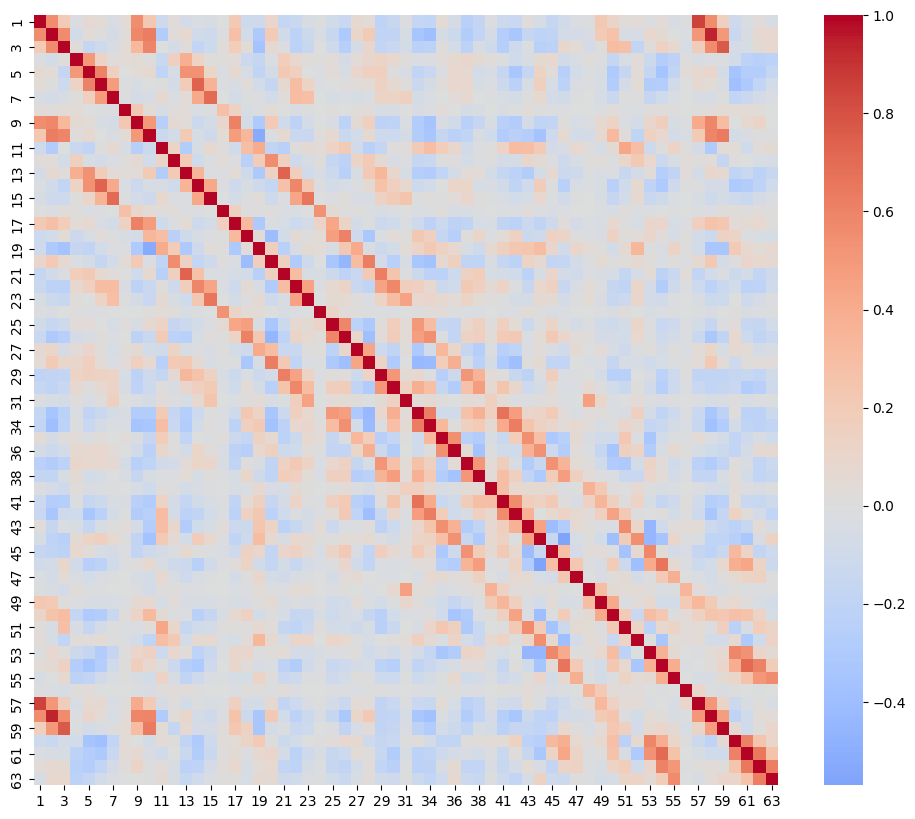

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from factor_analyzer.factor_analyzer import calculate_kmo
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale

# Load and standardize data
X, _ = load_digits(return_X_y=True)
X = scale(X)  # Standardizing the data

# Convert to DataFrame for easier manipulation
df = pd.DataFrame(X)

# Note the the digits data is missing two pixels - this will cause KMO analysis to break, and result in NA's in the correlation matrix.
# Check for constant features
constant_columns = df.columns[df.nunique() <= 1]
print(f"Constant columns: {constant_columns}")

# Drop constant columns if any
df = df.drop(columns=constant_columns)

# Calculate the KMO values
kmo_all, kmo_model = calculate_kmo(df)

print(f"KMO Model: {kmo_model}")

# If KMO Model is less than 0.6, data is not suitable for factor analysis.
# As the 'digits' dataset is known to be good for factor analysis,
# the KMO should be well above 0.6.

# Correlation analysis
corr_matrix = df.corr()

# Plotting the correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.show()


### A negative example

/Users/jeintron/Dropbox/@TEACHING/2023/FALL23/DEV/ist407-707.venv/lib/python3.10/site-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


KMO Model (Random Data): 0.48723562459170844


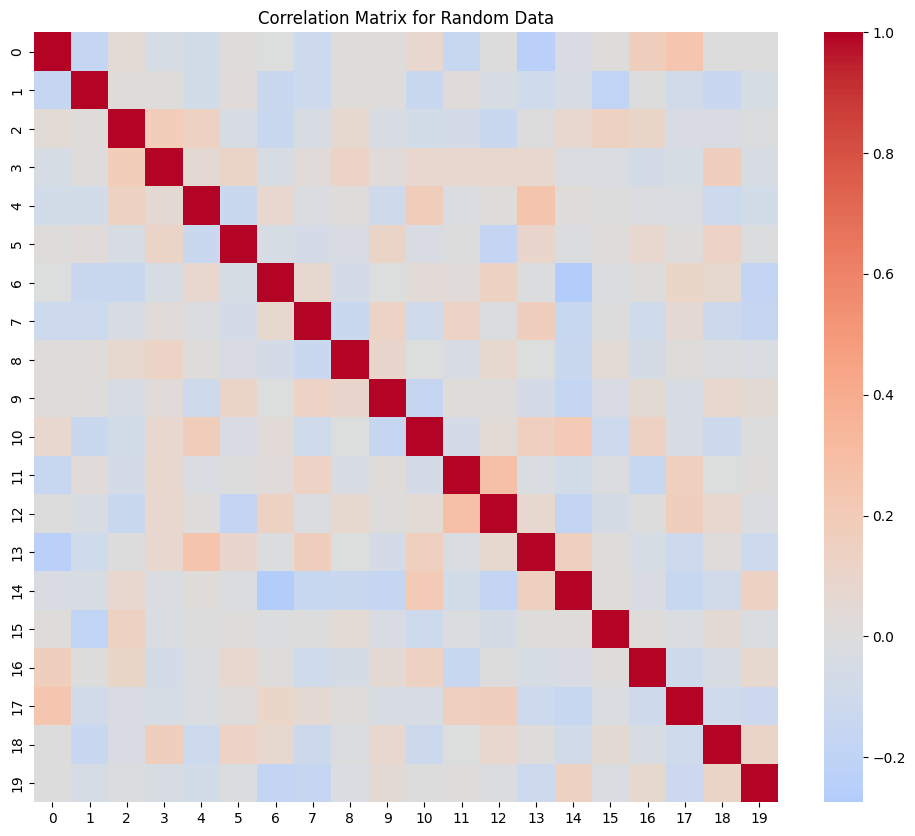

In [8]:
# Generating random data
np.random.seed(42)
X_random = np.random.rand(100, 20)  # 100 samples and 20 features

# Convert to DataFrame
df_random = pd.DataFrame(X_random)

# Calculate the KMO values
kmo_all_random, kmo_model_random = calculate_kmo(df_random)

print(f"KMO Model (Random Data): {kmo_model_random}")

# The KMO for random data should be low, indicating unsuitability for factor analysis.

# Correlation analysis for random data
corr_matrix_random = df_random.corr()

# Plotting the correlation heatmap for random data
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix_random, cmap='coolwarm', center=0)
plt.title('Correlation Matrix for Random Data')
plt.show()


2. **Choosing the Number of Factors**: In addition to theoretically motivated hypotheses, you can also apply the Kaiser criterion (eigenvalues >1) or scree plot analysis. These help determine the number of underlying factors that sufficiently capture the variability in the data


Eigenvalues: [7.34068882 5.83224319 5.15109308 3.96402882 2.96469447 2.57061312
 2.40467051 2.06752236 1.82891482 1.78852156 1.69690133 1.57200361
 1.38793502 1.35857964 1.32078995 1.16764163 1.08308372 0.99922226
 0.9738407  0.90840662 0.82226144 0.77587814 0.71116078 0.64516443
 0.59494273 0.57618098 0.52643843 0.51035214 0.48659288 0.45534754
 0.44260511 0.42206586 0.39888421 0.39088347 0.36074431 0.34840907
 0.31941845 0.29390263 0.27676875 0.25812928 0.24769237 0.24222173
 0.21746091 0.20788018 0.19997955 0.18972952 0.17603093 0.16865845
 0.15809671 0.14303463 0.13313668 0.12419456 0.11926258 0.11182428
 0.1024473  0.098354   0.09013524 0.08242223 0.07631145 0.0632544
 0.05034641]
Number of factors (Kaiser criterion): 17


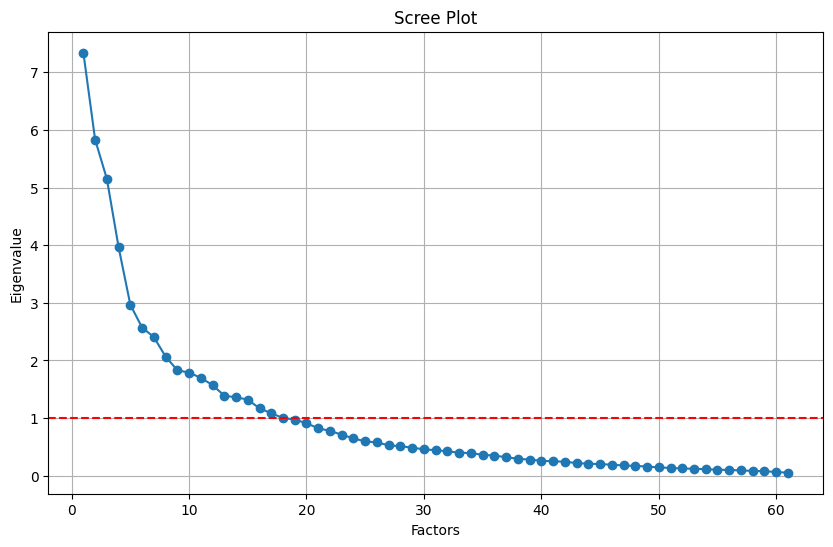

In [13]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from factor_analyzer import FactorAnalyzer

# Load the digits data
X, _ = load_digits(return_X_y=True)

# Find which columns in X have non-zero variance (i.e., remove empty pixels)
non_zero_variance_mask = np.var(X, axis=0) > 0
X = X[:, non_zero_variance_mask]

# Initialize FactorAnalyzer with a high number of possible factors
fa = FactorAnalyzer(n_factors=X.shape[1], rotation=None, method='minres')
fa.fit(X)

# Get eigenvalues and check how many are greater than 1 (Kaiser criterion)
ev, _ = fa.get_eigenvalues()
n_factors_kaiser = sum(ev > 1)
print(f'Eigenvalues: {ev}')
print(f'Number of factors (Kaiser criterion): {n_factors_kaiser}')

# Scree plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, X.shape[1] + 1), ev, marker='o')
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.axhline(y=1, color='r', linestyle='--')
plt.grid()
plt.show()



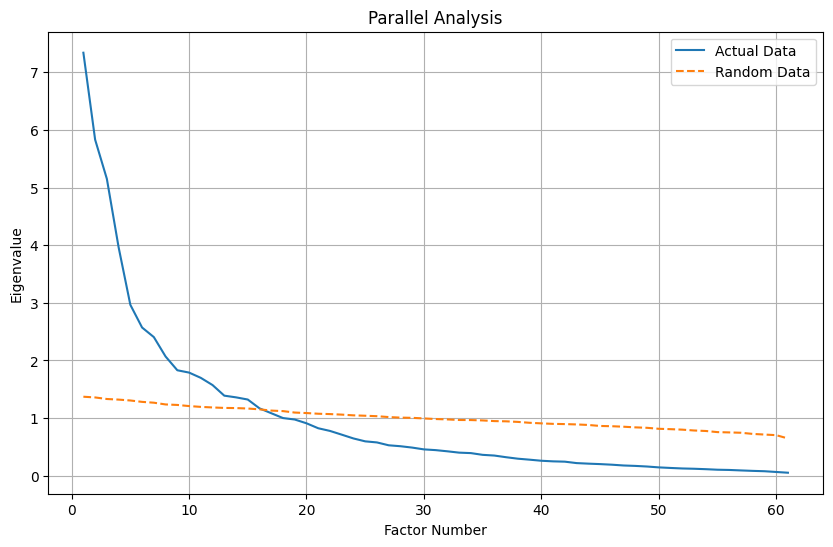

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_kmo, calculate_bartlett_sphericity
from sklearn.datasets import load_digits
from scipy.stats import norm

# Load the digits dataset
X, _ = load_digits(return_X_y=True)

# Find which columns in X have non-zero variance (i.e., remove empty pixels)
non_zero_variance_mask = np.var(X, axis=0) > 0
X = X[:, non_zero_variance_mask]

# Check for the adequacy of the dataset
chi_square_value, p_value = calculate_bartlett_sphericity(X)
kmo_all, kmo_model = calculate_kmo(X)

# Factor Analysis
fa = FactorAnalyzer(rotation=None, impute='drop', n_factors=X.shape[1])
fa.fit(X)
eigen_values, _ = fa.get_eigenvalues()

# Perform Parallel Analysis
np.random.seed(0)
rand_data = np.random.normal(0, 1, size=X.shape)
fa_random = FactorAnalyzer(rotation=None, impute='drop', n_factors=X.shape[1])
fa_random.fit(rand_data)
random_eigen_values, _ = fa_random.get_eigenvalues()

# Plot actual vs random eigenvalues
plt.figure(figsize=(10, 6))
plt.plot(range(1, X.shape[1]+1), eigen_values, label='Actual Data')
plt.plot(range(1, X.shape[1]+1), random_eigen_values, label='Random Data', linestyle='--')
plt.xlabel('Factor Number')
plt.ylabel('Eigenvalue')
plt.title('Parallel Analysis')
plt.legend()
plt.grid(True)
plt.show()




### Running Factor Analysis:

4. **Fitting the Model**: In scikit-learn, you would create a `FactorAnalysis` object and fit it to your data using the `fit` method. Under the hood, the algorithm is using a maximum likelihood approach to estimate the loadings (the relationship strength between variables and factors) and unique variances.


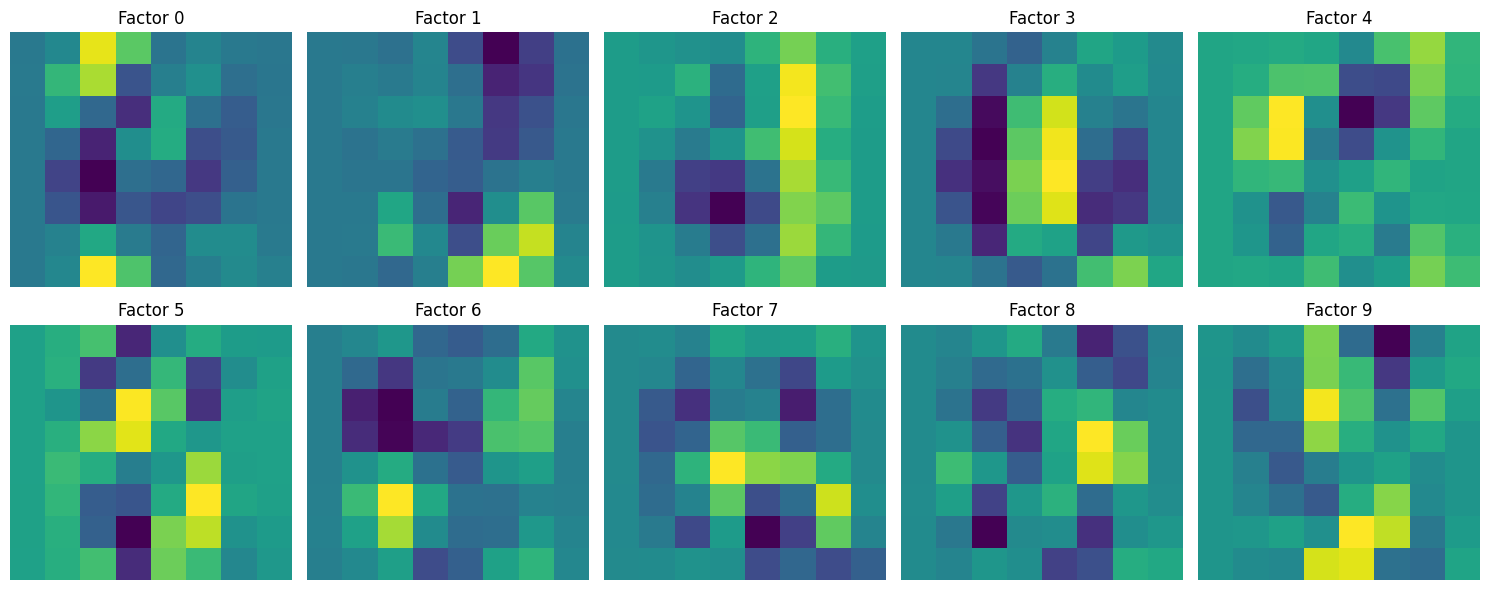

In [68]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_digits
from sklearn.decomposition import FactorAnalysis

# Load the digits dataset
X, y = load_digits(return_X_y=True)

# Perform factor analysis with 10 components
fa = FactorAnalysis(n_components=10, random_state=0)
fa.fit(X)

# We'll create a figure with 2 rows and 5 columns
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i, ax in enumerate(axes):
    # Reshape the loadings to 8x8
    loading = fa.components_[i].reshape(8, 8)
    
    # Create a heatmap for each loading, remove the axis labels and ticks
    sns.heatmap(loading, ax=ax, cmap='viridis', cbar=False)
    ax.set_title(f'Factor {i}')
    ax.axis('off')

plt.tight_layout()
plt.show()

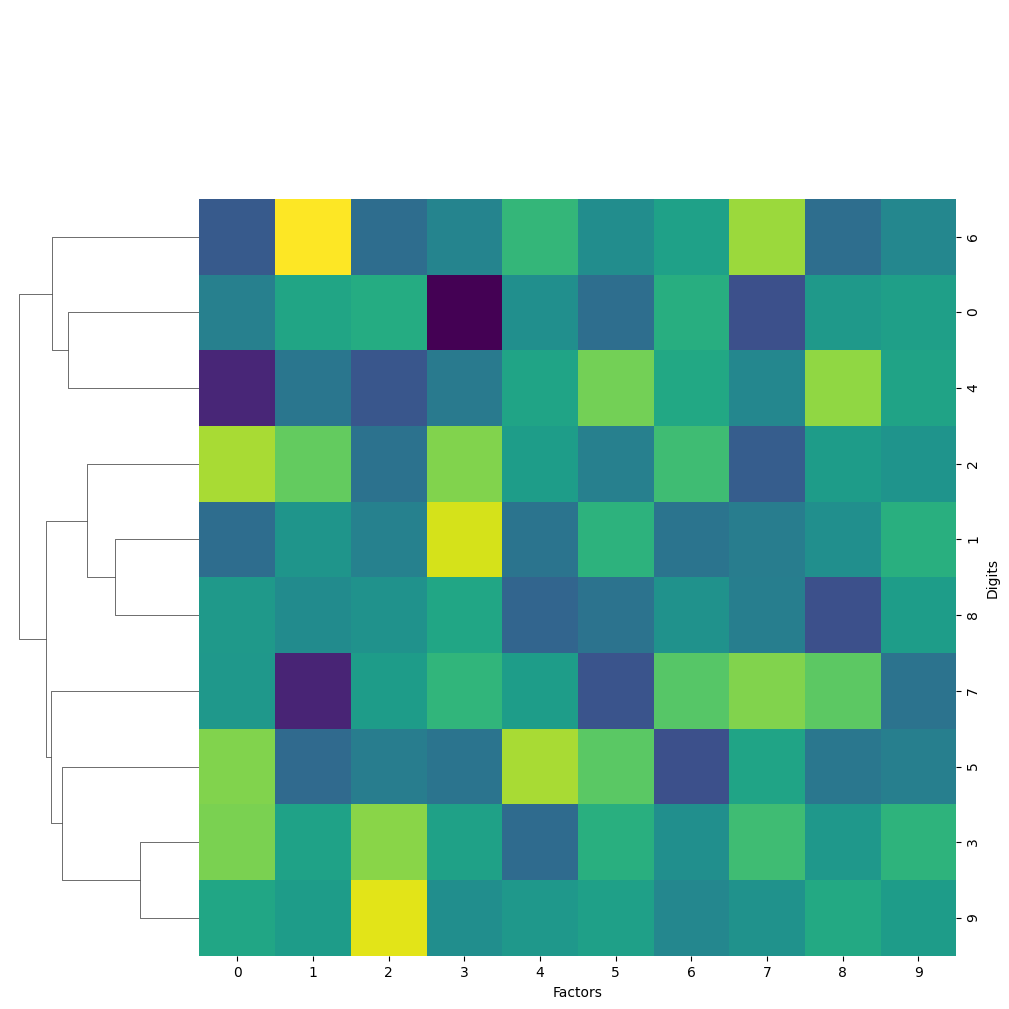

In [74]:
# Let's look at how factors load for the different digits

digit_factor_loadings = np.zeros((10, 10))
for digit in range(10):
    digit_data = X[y == digit]
    digit_factors = fa.transform(digit_data)
    digit_factor_loadings[digit, :] = np.mean(digit_factors, axis=0)

# Visualize the average loadings for each digit
g = sns.clustermap(digit_factor_loadings, col_cluster=False,method='ward', cmap='viridis')

# Hide the color bar (legend)
g.cax.set_visible(False)

#g.ax_heatmap.set_position([.25, 0, 0.9, 0.9])
g.ax_heatmap.set_xlabel('Factors')
g.ax_heatmap.set_ylabel('Digits') 
plt.show()



5. **Factor Rotation**: This is an optional step, but can be performed to achieve a simpler and more interpretable structure. It involves applying orthogonal or oblique rotations to the factor loadings. This is just a parameter to sklearn's factor analysis routine.

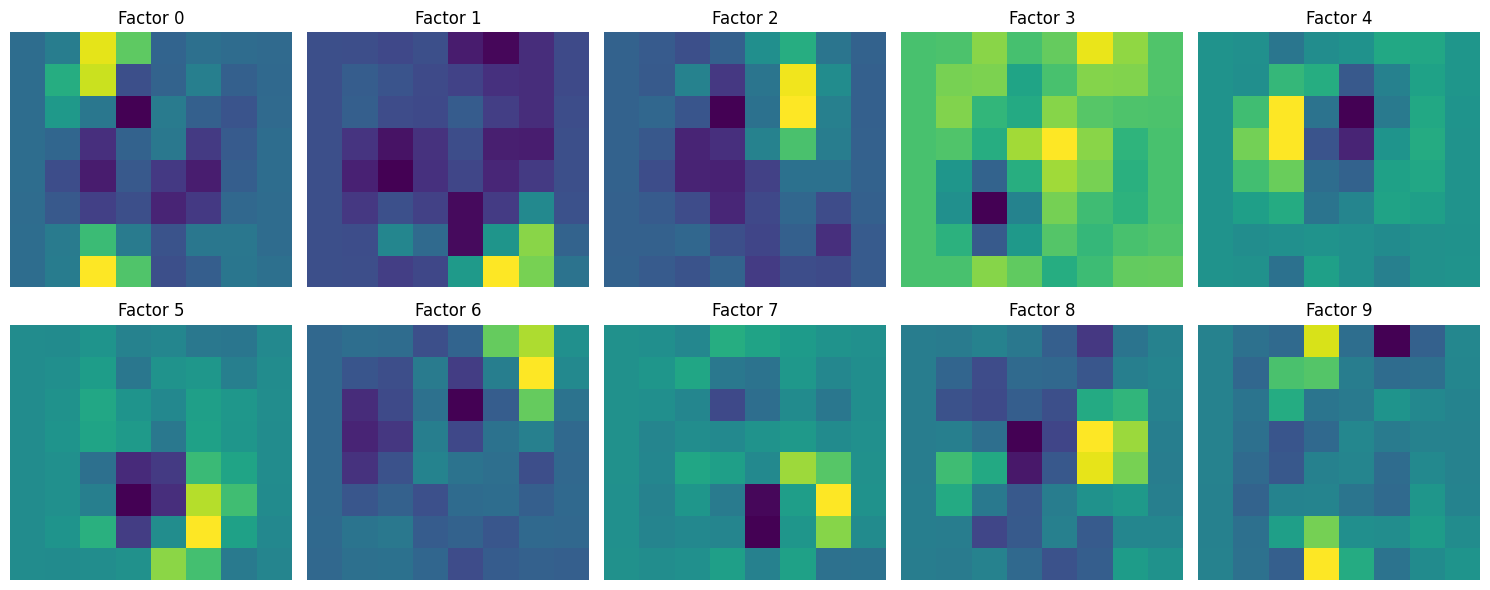

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_digits
from sklearn.decomposition import FactorAnalysis

# Load the digits dataset
X, y = load_digits(return_X_y=True)

# Perform factor analysis with 10 components
fa = FactorAnalysis(n_components=10, random_state=0, rotation="varimax")
fa.fit(X)

# We'll create a figure with 2 rows and 5 columns
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i, ax in enumerate(axes):
    # Reshape the loadings to 8x8
    loading = fa.components_[i].reshape(8, 8)
    
    # Create a heatmap for each loading, remove the axis labels and ticks
    sns.heatmap(loading, ax=ax, cmap='viridis', cbar=False)
    ax.set_title(f'Factor {i}')
    ax.axis('off')

plt.tight_layout()
plt.show()

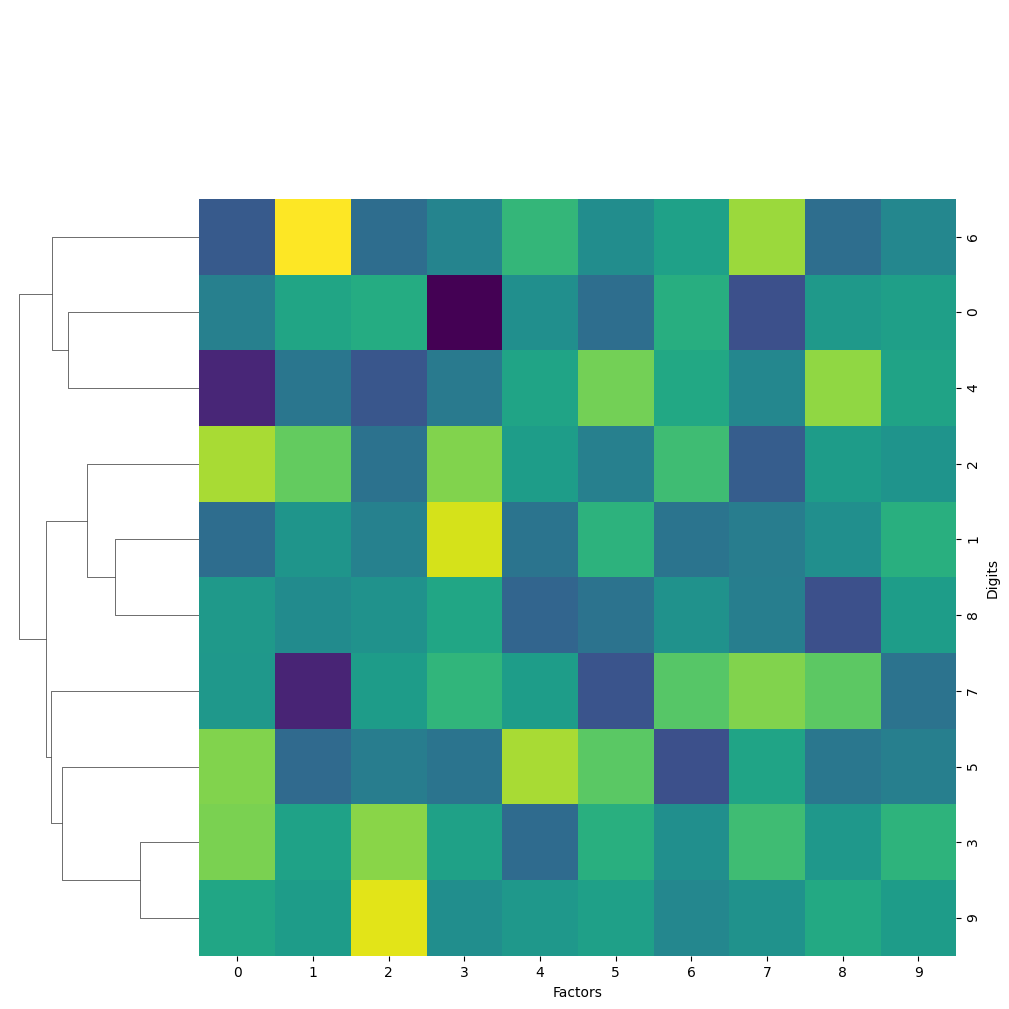

In [75]:
digit_factor_loadings = np.zeros((10, 10))
for digit in range(10):
    digit_data = X[y == digit]
    digit_factors = fa.transform(digit_data)
    digit_factor_loadings[digit, :] = np.mean(digit_factors, axis=0)

# Visualize the average loadings for each digit
g = sns.clustermap(digit_factor_loadings, col_cluster=False,method='ward', cmap='viridis')

# Hide the color bar (legend)
g.cax.set_visible(False)

g.ax_heatmap.set_xlabel('Factors')
g.ax_heatmap.set_ylabel('Digits') 
plt.show()





### Interpretation:

In addition to examining the factor loadings (above) you can also examine `communalities` and `unique variances`.  

7. **Communalities**: This is the proportion of each variable's variance that is explained by the factors. A higher communality indicates that more of the variance is captured by the model.
   - High Communalities: If a variable has a high communality, it means that most of its variance is accounted for by the extracted factors. This implies that the factor model is a good fit for this variable.

   - Low Communalities: On the other hand, if a variable has a low communality, it means that the extracted factors do not explain much of its variance. This might suggest that the variable is unique or that it might be influenced by factors that are not captured by the model.


In [45]:
loadings = fa.components_.T
communalities = np.sum(loadings**2, axis=1)
communality_df = pd.DataFrame(communalities, columns=['Communality'])
print("\nCommunalities:")
print(communality_df)


Communalities:
     Communality
0   5.396830e-44
1   3.871142e-01
2   2.112192e+01
3   1.388052e+01
4   3.841547e+00
..           ...
59  1.387607e+01
60  1.615155e+01
61  2.834582e+01
62  1.441677e+01
63  1.898593e+00

[64 rows x 1 columns]


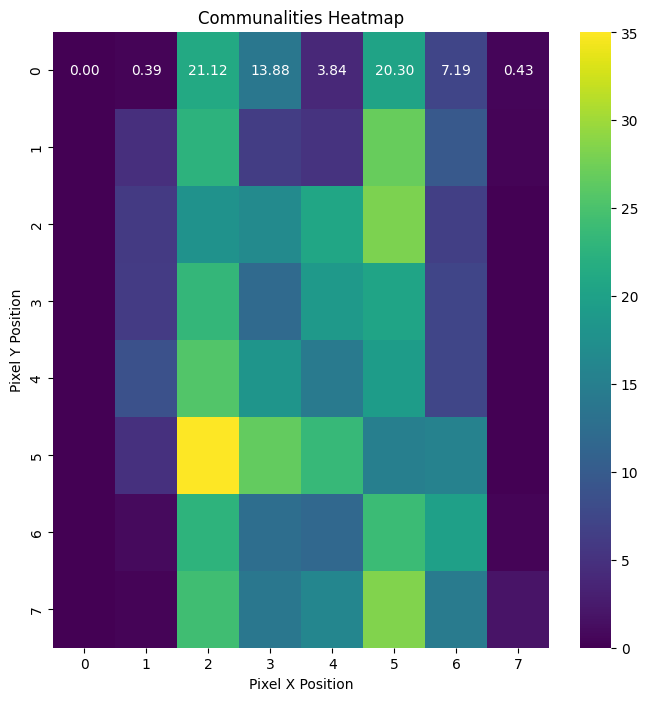

In [48]:
# As a heatmap
communalities_matrix = communalities.reshape(8, 8)
plt.figure(figsize=(8, 8))
sns.heatmap(communalities_matrix, cmap='viridis', annot=True, fmt=".2f")
plt.title('Communalities Heatmap')
plt.xlabel('Pixel X Position')
plt.ylabel('Pixel Y Position')
plt.show()



8. **Unique Variances**: Scikit-learn also provides unique variances which are variances of each variable that are not explained by the model.


In [51]:
unique_variances = fa.noise_variance_
unique_variance_df = pd.DataFrame(unique_variances, columns=['Unique Variance'])

print("\nUnique Variances:")
print(unique_variance_df)


Unique Variances:
    Unique Variance
0      1.000000e-12
1      4.320652e-01
2      1.469740e+00
3      4.145128e+00
4      1.448956e+01
..              ...
59     5.196695e+00
60     8.227597e+00
61     6.455387e+00
62     2.328854e+00
63     1.549125e+00

[64 rows x 1 columns]


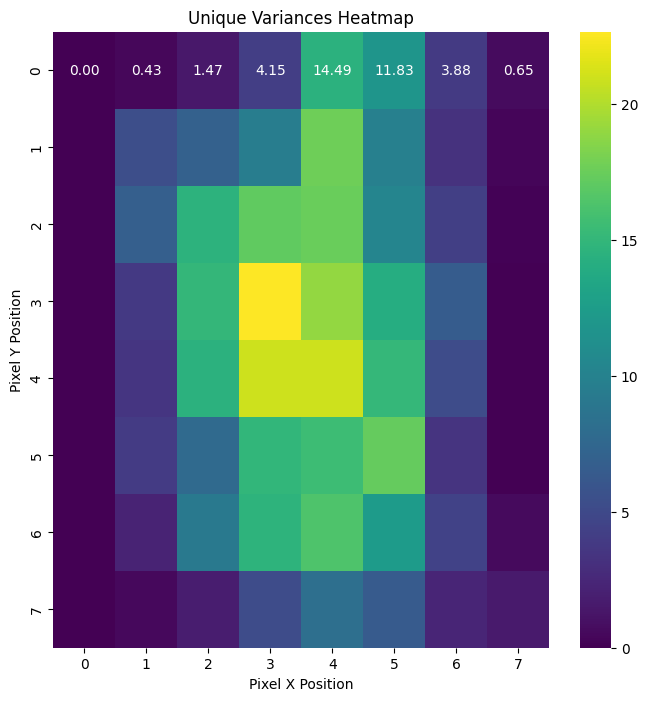

In [52]:
# As a heatmap
unique_variances_matrix = unique_variances.reshape(8, 8)
plt.figure(figsize=(8, 8))
sns.heatmap(unique_variances_matrix, cmap='viridis', annot=True, fmt=".2f")
plt.title('Unique Variances Heatmap')
plt.xlabel('Pixel X Position')
plt.ylabel('Pixel Y Position')
plt.show()

### Exercise

- Try using factor analysis on the `iris` data.  Compare PCA, unrotated FA, and Varimax FA, all with 2 components.  Use heatmaps to inspect the relationship between components and the different features.  What do you observe?

# Adaptive Techniques

Adaptive techniques seek to preserve complex, non-linear relationships between data points. Unlike linear methods like PCA, which apply a rigid transformation to all points in the dataset equally, adaptive methods tweak and optimize the transformation for different regions of the data space. In simpler terms, they adapt to the underlying data distribution.

This adaptability often makes these techniques more suitable for capturing and preserving intricate structures in high-dimensional data, such as clusters or manifolds.  However, they are often stochastic and are not guaranteed to preserve distances in the transformed data, so may not be suitable in all cases.  They are, however, excellent for visualization and some kinds of classification problems.


## t-SNE (t-Distributed Stochastic Neighbor Embedding)

t-SNE is particularly effective for visualizing high-dimensional data in 2D or 3D.
 
#### How it Works:

1. **Probability Distributions**: t-SNE starts by calculating the pairwise similarities between points in the high-dimensional space and in the low-dimensional space. These similarities are converted into conditional probabilities that a point would pick another point as its neighbor if neighbors were picked in proportion to their similarity.

2. **Minimize the Divergence**: t-SNE aims to minimize the difference between these two probability distributions for the high-dimensional and low-dimensional spaces. Specifically, it minimizes the Kullback-Leibler divergence between them.

3. **t-Distribution**: To calculate the similarity between points in the low-dimensional space, t-SNE uses a t-distribution, which has heavier tails compared to a normal distribution. This allows t-SNE to be particularly sensitive to local structures.

#### Strengths:

- Excellent at preserving local cluster structures.
- Particularly useful for visualization.

#### Weaknesses:

- Computationally intensive.
- May not preserve global structures well.
- The results are sensitive to hyperparameters like perplexity and the learning rate.
- **IMPORTANT** t-SNE does not enable "training" - you cannot fit a model a and then apply it to new data.  As a result, it is not really appopriate for train / test scenarios.

t-SNE has been a popular choice for tasks like visualizing gene expression data, understanding neural network activations, clustering, and much more.

With t-SNE, it's easier to capture the non-linear manifolds and groupings in data, making it an excellent tool for exploratory data analysis. However, because it's computationally demanding and somewhat unpredictable, it may not always be the best choice for all types of dimensionality reduction tasks.

---

### Example

A classic example of data that PCA struggles with is the `swiss roll`, which you can envision as a sheet of paper rolled into a tube.  You'll see the PCA manages to uncover the spiral, but not it's "sheet-like" properties.

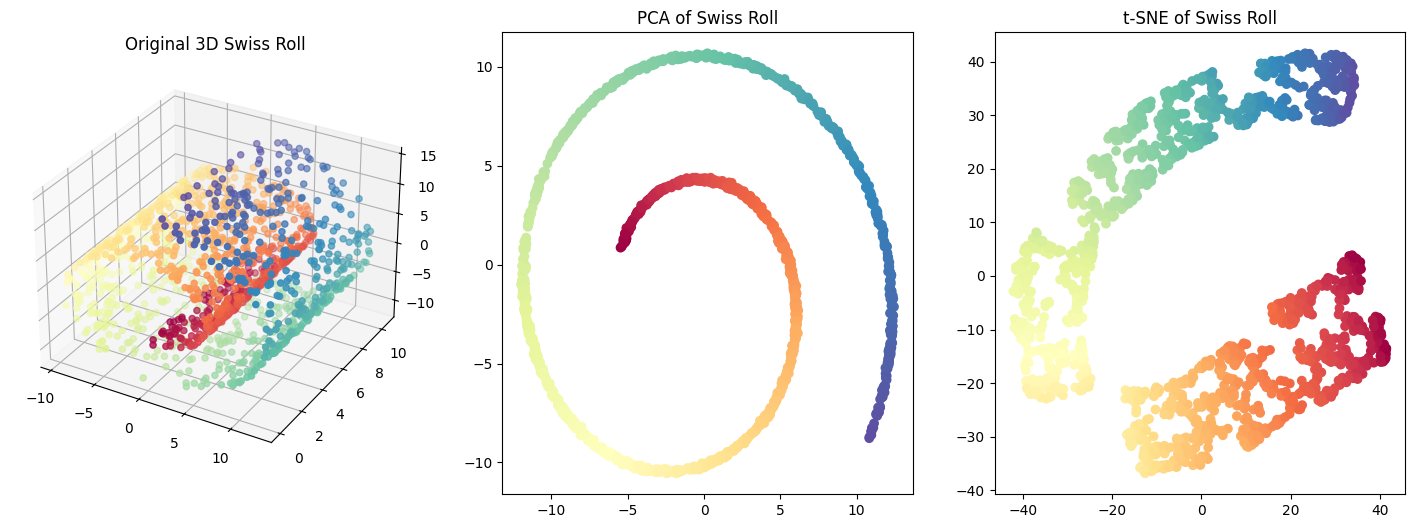

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.datasets import make_swiss_roll
from mpl_toolkits.mplot3d import Axes3D

# Create Swiss Roll data
n_samples = 1500
noise = 0.05
X, color = make_swiss_roll(n_samples, noise=noise)
# Make it thinner
X[:, 1] *= .5

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(X)

# Visualization
fig = plt.figure(figsize=(18, 6))

# 3D Swiss Roll
ax0 = fig.add_subplot(131, projection='3d')
ax0.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
ax0.set_title("Original 3D Swiss Roll")

# PCA
ax1 = fig.add_subplot(132)
ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=color, cmap=plt.cm.Spectral)
ax1.set_title("PCA of Swiss Roll")

# t-SNE
ax2 = fig.add_subplot(133)
ax2.scatter(X_tsne[:, 0], X_tsne[:, 1], c=color, cmap=plt.cm.Spectral)
ax2.set_title("t-SNE of Swiss Roll")

plt.show()


## Exercise 3

Try using t-SNE to visualize the MNIST data above.  How does it compare to PCA?

In [ ]:
# Now, try runing the KNN algorithm again.  How does the classifier perform now?

## UMAP (Uniform Manifold Approximation and Projection)

UMAP is a newer technique for dimensionality reduction and data visualization, like t-SNE. It is designed to provide more robust results and be computationally efficient, making it suitable for larger datasets.

### Key Features of UMAP:

1. **Preservation of Topology:** UMAP aims to preserve not just local but also global data structures. The emphasis on global / local structure can be controlled by parameters. In comparison, t-SNE excels at preserving local structures but may not always capture the global relationships as accurately.

2. **Computational Efficiency:** UMAP is generally faster than t-SNE, especially for larger datasets, making it a more scalable option.

3. **Versatility:** UMAP is not just for visualization; you can also use it for general non-linear dimensionality reduction tasks.

4. **Compatibility with Metrics:** Unlike t-SNE, which mainly uses Euclidean distance, UMAP can work with a variety of distance metrics.

### Working Principle:

1. **Mathematical Foundations:** UMAP is grounded in rigorous mathematics, specifically the theory of Riemannian geometry and algebraic topology.

2. **Manifold Learning:** Similar to t-SNE, UMAP also operates on the principle that the data is sampled from some low-dimensional manifold embedded in a high-dimensional space. It works to learn this manifold structure.

3. **Graph-based Approach:** UMAP first constructs a weighted k-NN graph for the data in the original space. It then optimizes a similar graph in the lower-dimensional space to be as structurally similar to the original graph as possible.

<div class="alert alert-block alert-info"> <b>Low dimensional manifolds</b>: A "low-dimensional manifold" refers to a manifold of lower dimensionality than the space in which it is embedded. For example, consider a two-dimensional sheet of paper that is crumpled and placed in a three-dimensional room. Despite the crumpling, each point on the paper still has a neighborhood that resembles a flat, 2D plane. Thus, the crumpled paper represents a 2D manifold within the 3D space of the room.

The concept of a low-dimensional manifold is often invoked to suggest that the meaningful dimensions of the data are fewer than the number of columns in the data table. For instance, you might have a 1,000-dimensional dataset that actually lies along a curved, 10-dimensional surface within that 1,000-dimensional space. Machine learning techniques like manifold learning aim to discover this low-dimensional surface (or manifold), making the data easier to visualize, understand, and work with.
</div>

In [ ]:
# You'll need to install UMAP learn for UMAP
# Unfortunately, UMAP learn currently depends on an older version of numpy
# To handle this, you'll want to create a new environment, install the necessary libraries
# and switch to this kernel for all processing

!pip install numpy==1.24
!pip install umap-learn
!pip install matplotlib
!pip install pandas

### Example

Here's an example with the `Swiss roll` - note that both seem to do a pretty good job, but UMAP is quite a bit faster!

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll
from sklearn.manifold import TSNE
import umap
from mpl_toolkits.mplot3d import Axes3D  # Import for 3D plotting
import time

# Generate Swiss roll data
n_samples = 1500
noise = 0.05
X, color = make_swiss_roll(n_samples, noise=noise)

# Apply t-SNE
start_time_tsne = time.time()
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)
end_time_tsne = time.time()

# Apply UMAP
start_time_umap = time.time()
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
X_umap = umap_model.fit_transform(X)
end_time_umap = time.time()

elapsed_tsne = end_time_tsne - start_time_tsne
elapsed_umap = end_time_umap - start_time_umap
print(f"Time elapsed for t-SNE: {elapsed_tsne:.4f} seconds")
print(f"Time elapsed for UMAP: {elapsed_umap:.4f} seconds")


# Plot the data
fig = plt.figure(figsize=(18, 6))

# Original Swiss roll in 3D
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
ax1.set_title('Original Swiss Roll in 3D')
ax1.set_xlabel('X-axis')
ax1.set_ylabel('Y-axis')
ax1.set_zlabel('Z-axis')

# t-SNE plot
ax2 = fig.add_subplot(132)
ax2.scatter(X_tsne[:, 0], X_tsne[:, 1], c=color, cmap=plt.cm.Spectral)
ax2.set_title('t-SNE')
ax2.set_xlabel('t-SNE 1')
ax2.set_ylabel('t-SNE 2')

# UMAP plot
ax3 = fig.add_subplot(133)
ax3.scatter(X_umap[:, 0], X_umap[:, 1], c=color, cmap=plt.cm.Spectral)
ax3.set_title('UMAP')
ax3.set_xlabel('UMAP 1')
ax3.set_ylabel('UMAP 2')

plt.tight_layout()
plt.show()


### Understanding umap parameters

There is a wonderful [online tutorial](https://pair-code.github.io/understanding-umap/) that illustrates the impact of UMAP parameters.  I've replicated part of it here for you.  It uses data from a 3D scan of a Wooley Mammoth, curated by [Maximilian Noichl](https://homepage.univie.ac.at/maximilian.noichl/post/mammoth/).

The basic idea here is that the `nearest neighbors` parameter adjust sensitivity to global structure, and `min-dist` parameter controls the "fuzziness" of the embedding. 

In [ ]:
# First, here's the 3D mammoth
import pandas as pd
mammoth = pd.read_csv('./data/mammoth_a.csv')
mammoth = mammoth.sample(50000)


In [ ]:
# plotting
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(90,72))

ax = fig.add_subplot(111, projection='3d')
# ax.set_aspect('equal')

ax.scatter(mammoth['x'], mammoth['y'], mammoth['z'], s=20,c='black')
ax.view_init(20, -170)

plt.show()

The embeddings take a while to process, especially when the number of neighbors increases, but here's an example with a relatively low number of nearest neighbors.

In [ ]:
import matplotlib.pyplot as plt
import umap

umap = umap.UMAP(    init='random',
                    n_components=2,
                    n_neighbors=30,
                    min_dist=0.1,
                     spread=2,
                    metric='euclidean',
                    verbose=True)

mammoth_transformed = umap.fit(mammoth.values)

Note that UMAP has two methods, `fit` and `fit_transform`, like most scikit learn ML models.  With the `fit` method, UMAP will create a model that can then be applied to new data.  This is a kind of supervised learning, allowing you to build an embedding model on a small bit of data first, and then extending it larger data.  See the [UMAP documentation](https://umap-learn.readthedocs.io/en/latest/basic_usage.html#digits-data) page.

In [ ]:
plt.figure(figsize=(20,20),facecolor='w')
plt.axis('off')
plt.scatter(mammoth_transformed.embedding_[:, 0], mammoth_transformed.embedding_[:, 1], s=1,color='gray')

[Maximilian Noichl](https://homepage.univie.ac.at/maximilian.noichl/post/mammoth/) generated a few animations that help illustrate how UMAP behaves across different parameter settings.

#### Exploring Min Dist

![Min dist animation](./assets/mammoth_md.gif)

#### Exploring Nearest Neighbors

![Min dist animation](./assets/mammoth_nn.gif)

# Exercise 4

Try using UMAP to process the MNIST data.  Visualize the data first, and then calculate accuracy with KNN.

In [ ]:
# Code here - just use default parameters for UMAP
import umap
# Capture your data data in the following variable
X_umap = None


In [ ]:
plt.figure(figsize=(15,15))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y_mnist_train, cmap="Spectral",s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title("MNIST - 2D UMAP")
plt.show()

# Exercise 5

Try exploring the impact of dimensionality reduction using the following sample data.

1. How does a KNN classifier do as the number of dimensions increases?
2. Apply a PCA that captures 90% of the variance. Does it help?
3. Does UMAP help?
4. What explains the difference? 

Original Data Accuracy: 0.844


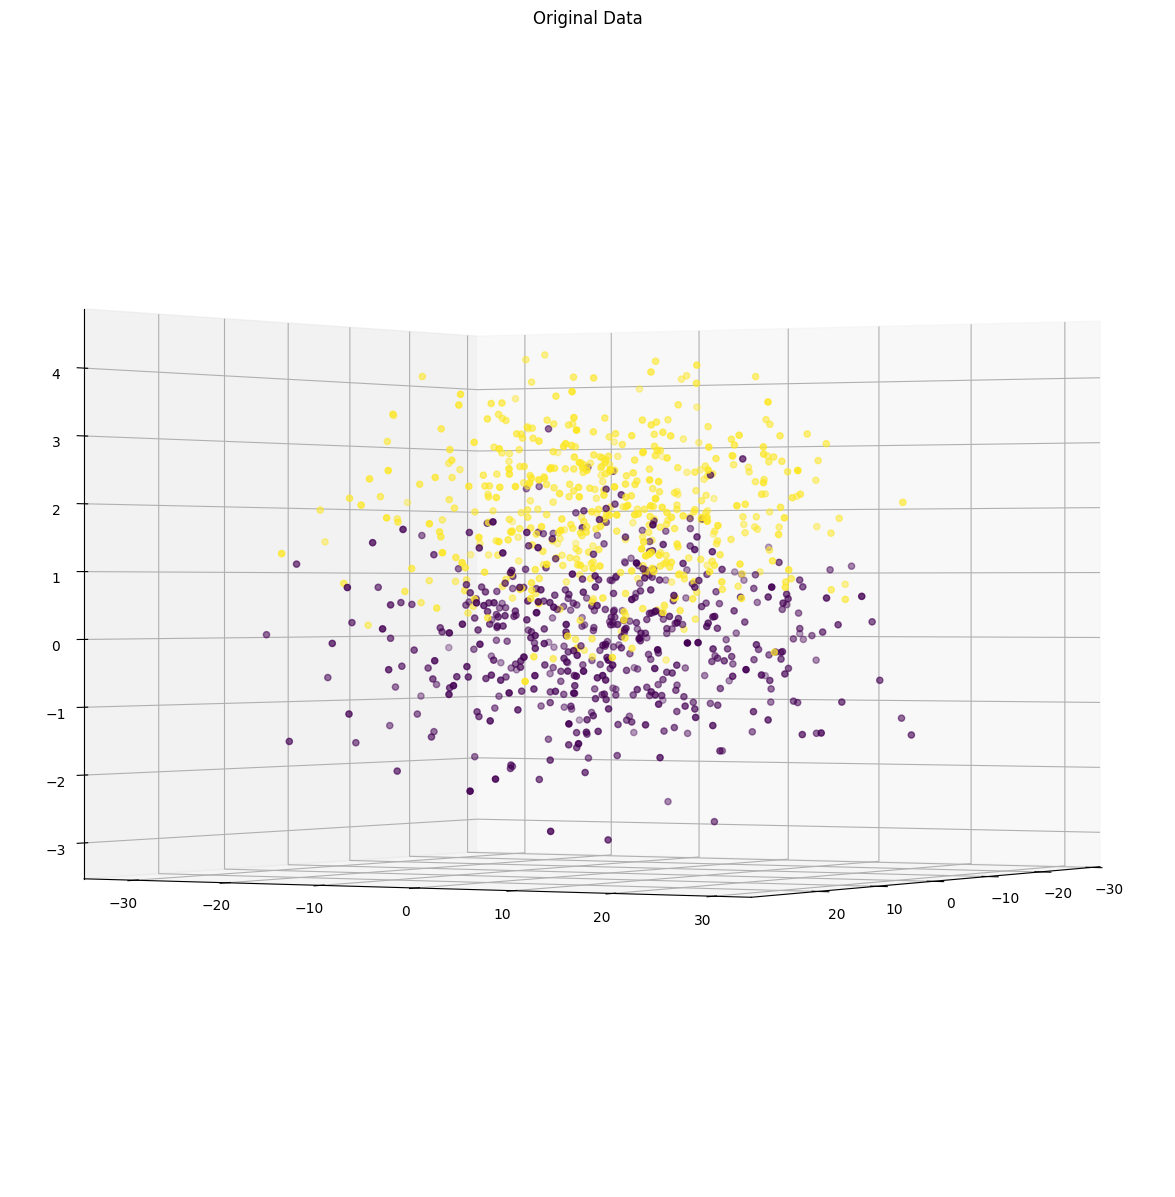

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


# Generate synthetic data
np.random.seed(0)
n_points = 500

# Class 0
x0 = np.random.normal(loc=0, scale=10, size=n_points)
y0 = np.random.normal(loc=0, scale=10, size=n_points)
z0 = np.random.normal(loc=0, scale=1, size=n_points)

# Class 1
x1 = np.random.normal(loc=0, scale=10, size=n_points)
y1 = np.random.normal(loc=0, scale=10, size=n_points)
z1 = np.random.normal(loc=2, scale=1, size=n_points)

X = np.vstack((np.hstack((x0, x1)), np.hstack((y0, y1)), np.hstack((z0, z1)))).T
y = np.hstack((np.zeros(n_points), np.ones(n_points)))



# Train KNN on original data
knn = KNeighborsClassifier()
knn.fit(X, y)
y_pred = knn.predict(X)
print(f"Original Data Accuracy: {accuracy_score(y, y_pred)}")

# Create a new figure
fig = plt.figure(figsize=(15,15))

# Add 3D subplot
# The format is (rows, columns, plot_number)
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=0, azim=30)

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap='viridis')
ax.set_title('Original Data')

plt.show()


